In [250]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import geopandas as gpd
import fiona

In [251]:
# Import the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')
oil = pd.read_csv('data/oil.csv')
holidays = pd.read_csv('data/holidays_events.csv')

# Delete some unnecessary columns
train = train.drop(labels=['id'],axis=1)

datasets = {'train':train, 'test':test, 'stores':stores, 'transactions':transactions, 'oil':oil, 'holidays':holidays}

In [252]:
# Standarize dates just in case
for df in iter(datasets.values()):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime( df['date'] )

In [253]:
# Import world cities data (source: https://simplemaps.com/data/world-cities )
cities = pd.read_csv('data/worldcities.csv')
# Find Ecuadorian cities
cities = cities[cities['country'] == "Ecuador"]
# Drop unnecessary columns
cities = cities.drop(labels=['country', 'city_ascii', 'capital', 'admin_name', 'iso2','iso3', 'id'],
                    axis=1)
cities = cities.reset_index(drop=True)

In [254]:
# Find cities with stores, that don't appear in the city df
set(stores['city'].unique()).difference(set(cities['city'].unique()))
    # Libertad and Santo Domingo ARE in among the cities
    # but under different names "La Libertad" and "Santo Domingo de los Colorados".
    # El Carmen does not seem to be in the city database

{'El Carmen', 'Libertad', 'Santo Domingo'}

In [255]:
# Fix city names for Libertad and Santo Domingo
cities.iat[cities.city[cities.city == 'Santo Domingo de los Colorados'].index.tolist()[0],0] = 'Santo Domingo'
cities.iat[cities.city[cities.city == 'La Libertad'].index.tolist()[0],0] = 'Libertad'

# Add data for El Carmen
carmen = pd.DataFrame(data=[['El Carmen', -0.27277, -79.46157, 52400]], columns=cities.columns.to_list())
cities = pd.concat([cities,carmen],ignore_index=True)

In [256]:
# Join geographic data to store.csv along city names
stores = pd.merge(left=stores, right=cities, how='inner')
stores = stores.sort_values(by='store_nbr',axis=0).reset_index(drop=True)   # returns rows to original order by store number

In [257]:
# GeoJSON file with Ecuador's provinces/state information (source: https://simplemaps.com/gis/country/ec#admin1)
states = gpd.read_file('data/ec.json')
# Drop unnecessary columns (and a row for an island)
states = states.drop(labels=['source','id'],axis=1)
states = states.drop(10,axis=0)
states = states.reset_index(drop=True)

<Axes: >

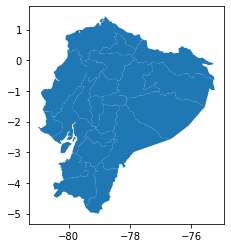

In [258]:
states.plot()

In [259]:
# Look for any differences between state names
print("Missing States:", set(stores.state.unique()).difference(set(states.name.unique())))

print("All States in GeoJSON file:",states.name.unique())
    # One state seems to be missing: 'Santo Domingo de los Tsachilas'

Missing States: {'Santo Domingo de los Tsachilas'}
All States in GeoJSON file: ['Esmeraldas' 'Carchi' 'Sucumbios' 'Orellana' 'Pastaza' 'Morona Santiago'
 'Zamora Chinchipe' 'Loja' 'El Oro' 'Guayas' 'Santa Elena' 'Manabi'
 'Azuay' 'Cañar' 'Napo' 'Tungurahua' 'Chimborazo' 'Bolivar' 'Imbabura'
 'Cotopaxi' 'Los Rios' 'Pichincha' 'Santo Domingo de los Tsáchilas']


In [260]:
# The missing state is there, just off by an accent
# We change it here to match stores.csv
states.iat[ states.name[states.name =='Santo Domingo de los Tsáchilas'].index.tolist()[0], 0 ] = 'Santo Domingo de los Tsachilas'

In [261]:
# Merge store data with geographic data into a GeoDataFrame
geo_stores = states.merge(stores, how='inner',left_on='name',right_on='state')
geo_stores = geo_stores.sort_values(by='store_nbr',axis=0).reset_index(drop=True)
geo_stores = geo_stores.drop(labels=['name'],axis=1)
geo_stores = geo_stores[['store_nbr','type','cluster','city','lat','lng','population','state','geometry']]

In [262]:
# Merge with total transactions per date, per store
geo_stores = geo_stores.merge(transactions, how='inner', on='store_nbr')
geo_stores = geo_stores.sort_values(by=['date','store_nbr'],axis=0).reset_index(drop=True)
geo_stores = geo_stores[['date','store_nbr','type','cluster','city','lat','lng','population','state','geometry','transactions']]

## Mean Transactions by City

In [263]:
mean_transactions_2013 = pd.DataFrame(data=geo_stores.loc[ geo_stores.date < pd.Timestamp(year=2014, month=1, day=1)].groupby(by='city').transactions.mean())
mean_transactions_2013= mean_transactions_2013.rename(columns={'transactions':2013})
mean_transactions_by_city = mean_transactions_2013

for year in [2015, 2016, 2017, 2018]:
    old_year = pd.Timestamp(year=year-1, month=1, day=1)
    new_year = pd.Timestamp(year=year, month=1, day=1)
    temp_df = geo_stores.loc[   old_year < geo_stores.date ][  geo_stores.date < new_year  ]
    column_to_add = temp_df.groupby(by='city').transactions.mean()
    mean_transactions_by_city[f'{year}'] = column_to_add

print(mean_transactions_by_city)

                      2013         2015         2016         2017         2018
city                                                                          
Ambato         1923.674931  1887.610193  1828.634986  1743.752762  1804.327434
Babahoyo       1285.757576  1378.619835  1441.732782  1385.757576  1382.725664
Cayambe        2462.804408  2430.223140  2318.856749  2296.767313  2324.960177
Cuenca         1435.363636  1497.918733  1410.799534  1306.040441  1346.380531
Daule          1267.482094  1437.702479  1554.636364  1566.309392  1647.646018
El Carmen       878.419890   878.763085   885.630854   851.497238   816.747788
Esmeraldas     1247.458564  1315.126722  1325.848485  1237.918994  1455.429204
Guaranda       1268.325069  1303.573003  1306.749311  1210.966759  1160.977876
Guayaquil      1412.907069  1345.195982  1311.831270  1270.839710  1278.987279
Ibarra         1324.826446  1286.749311  1350.063361  1314.587258  1315.296460
Latacunga      1101.823691  1076.117080  1089.451952

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [264]:
list_of_cities = mean_transactions_by_city.index.to_list()
years=[2013,2014,2015,2016,2017]

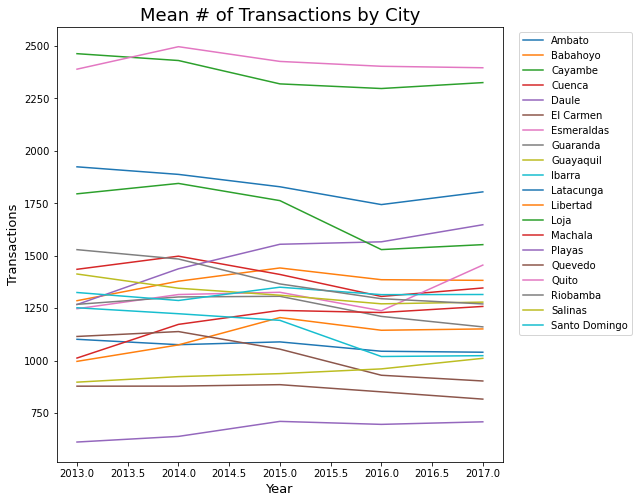

In [265]:
## making a Figure
plt.figure(figsize=(8,8))

for city in list_of_cities:
    plt.plot(years, mean_transactions_by_city.loc[city].values, label=city)


## Display the Figure
plt.title("Mean # of Transactions by City", fontsize=18)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Transactions", fontsize=13)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
plt.show()

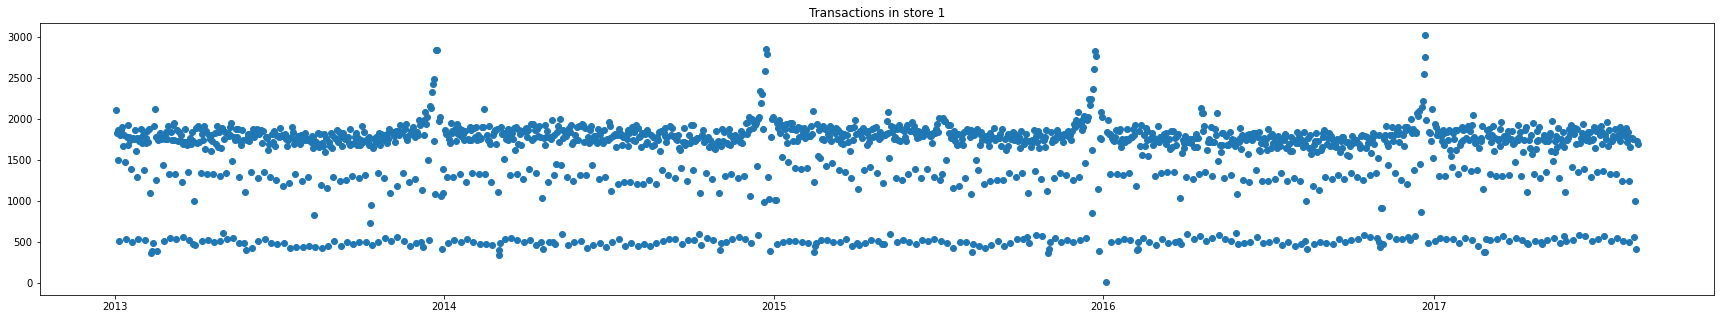

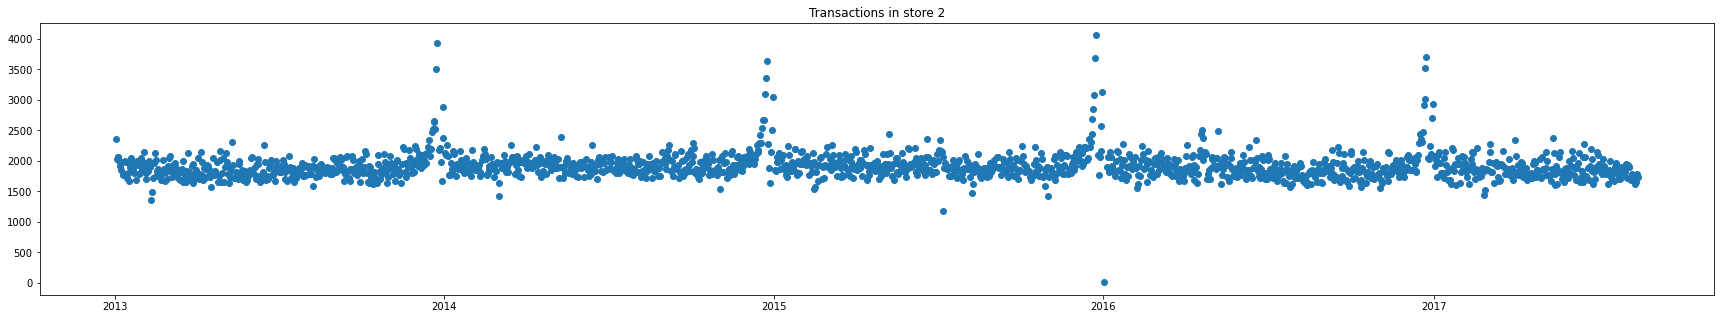

In [266]:
for n in range(2):
    temp = geo_stores[ geo_stores.store_nbr == n+1   ]
    x = temp.date
    y = temp.transactions
    fig = plt.figure(figsize=(30,5))
    plt.scatter(x,y)
    plt.title(f'Transactions in store {n+1}')
    

## Adding training data

In [267]:
# Merge with training set (i.e. breaking down total transactions by type of good) 
geo_stores_all = geo_stores.merge(train, how='inner', on=['date','store_nbr'])
geo_stores_all = geo_stores_all.sort_values(by=['date','store_nbr'],axis=0).reset_index(drop=True)
geo_stores_all = geo_stores_all[['date','store_nbr','type','cluster','city','lat','lng','population','state','geometry','transactions', 'family', 'sales', 'onpromotion']]

In [268]:
geo_stores_all.insert(1, "day_of_week", pd.Series( [geo_stores_all.date[i].dayofweek for i in range(len(geo_stores_all.date))]  ))

In [269]:
family = list(geo_stores_all.family.unique())

In [270]:
data_by_store = []

for store_num in range(1,55):
    temp_df = geo_stores_all[ geo_stores_all.store_nbr== store_num ].reset_index(drop=True)
    data_by_store.append(temp_df)

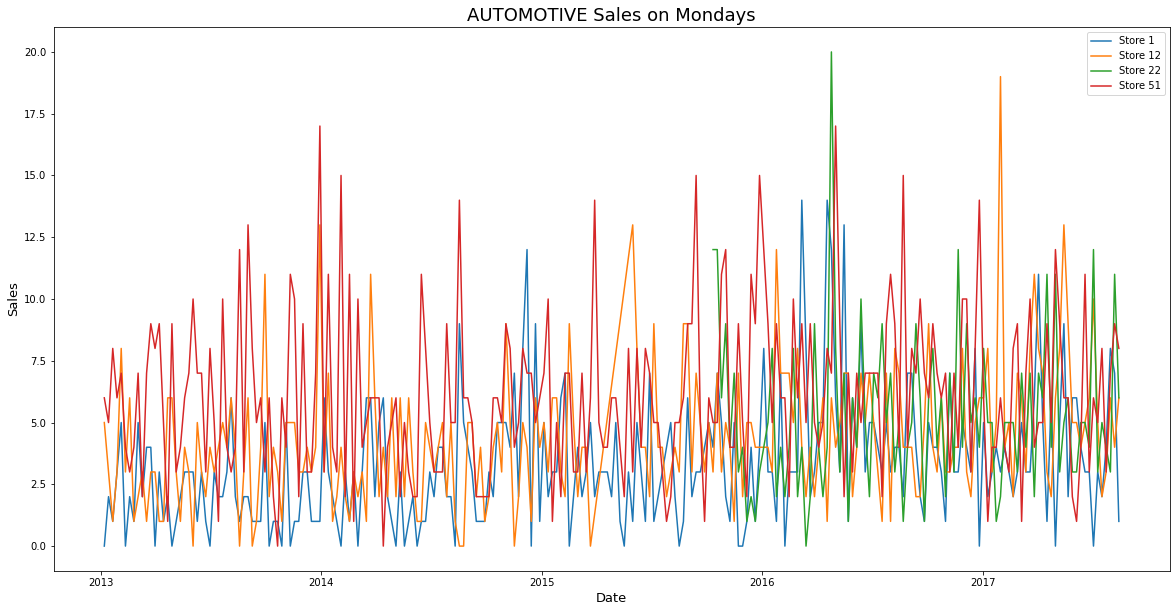

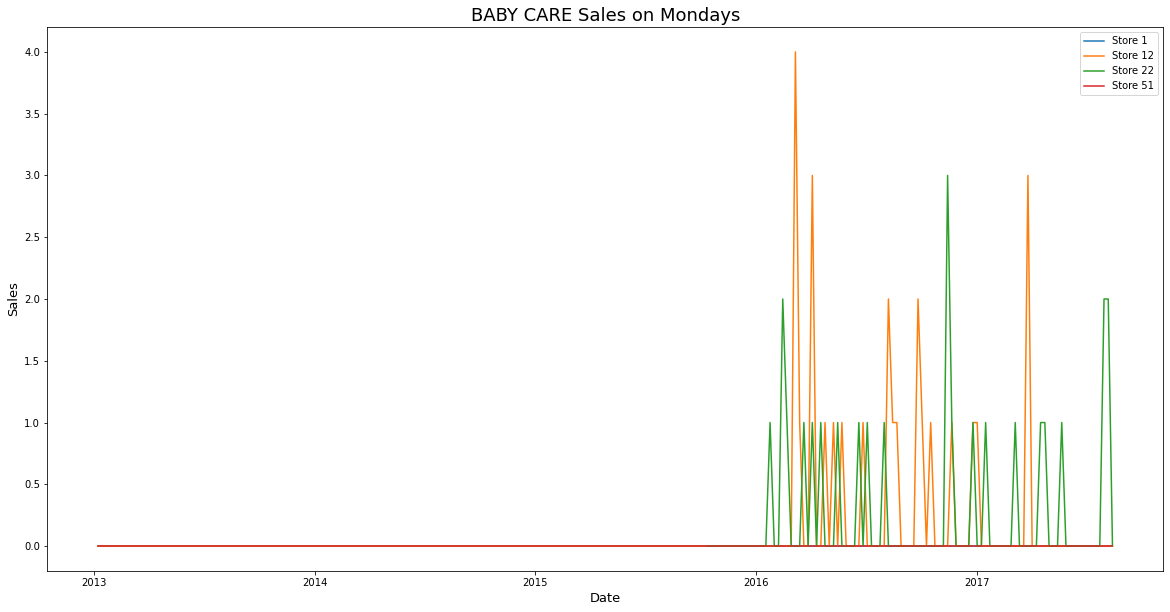

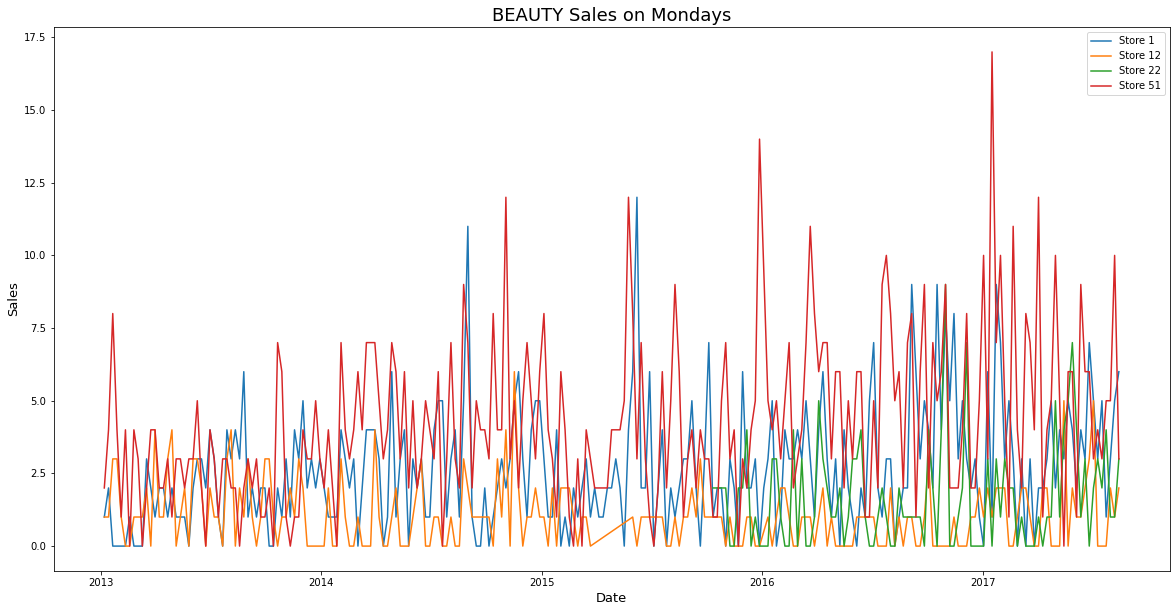

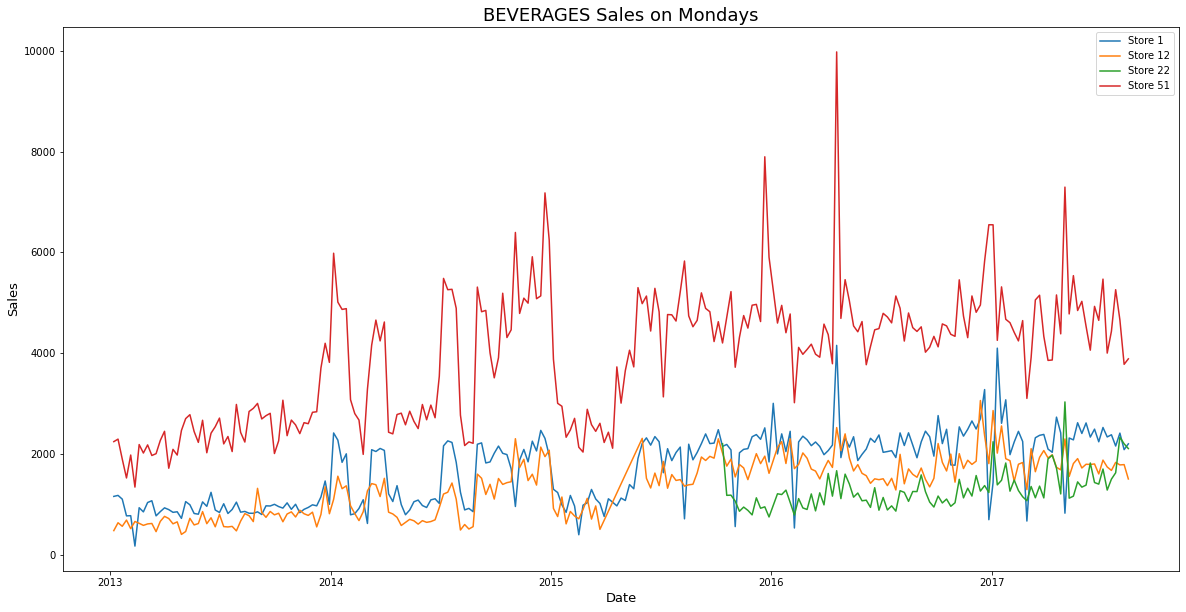

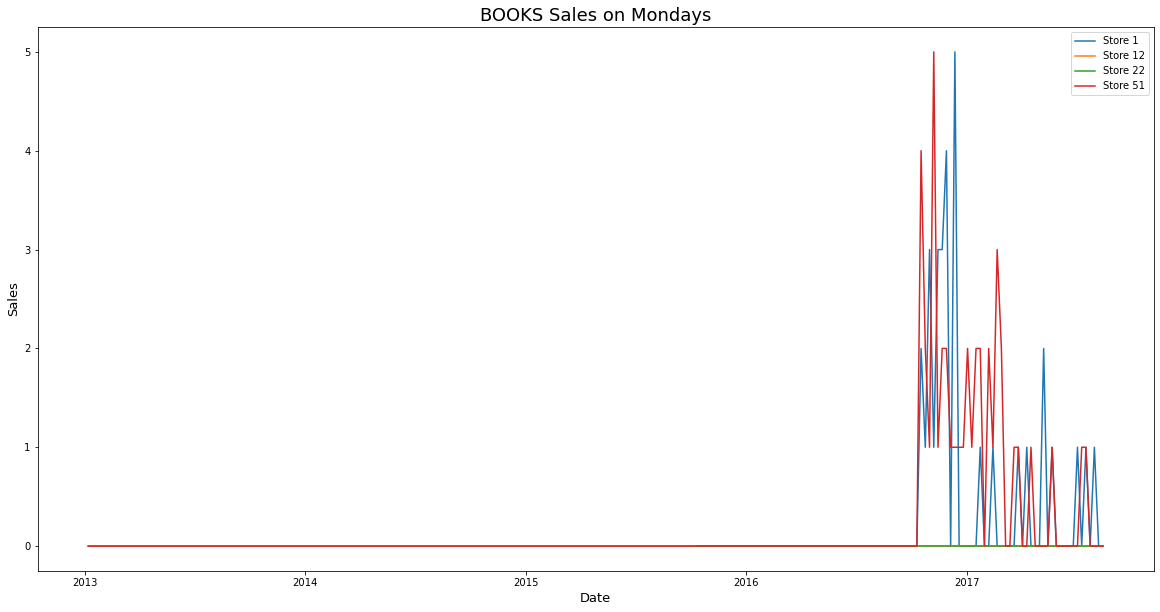

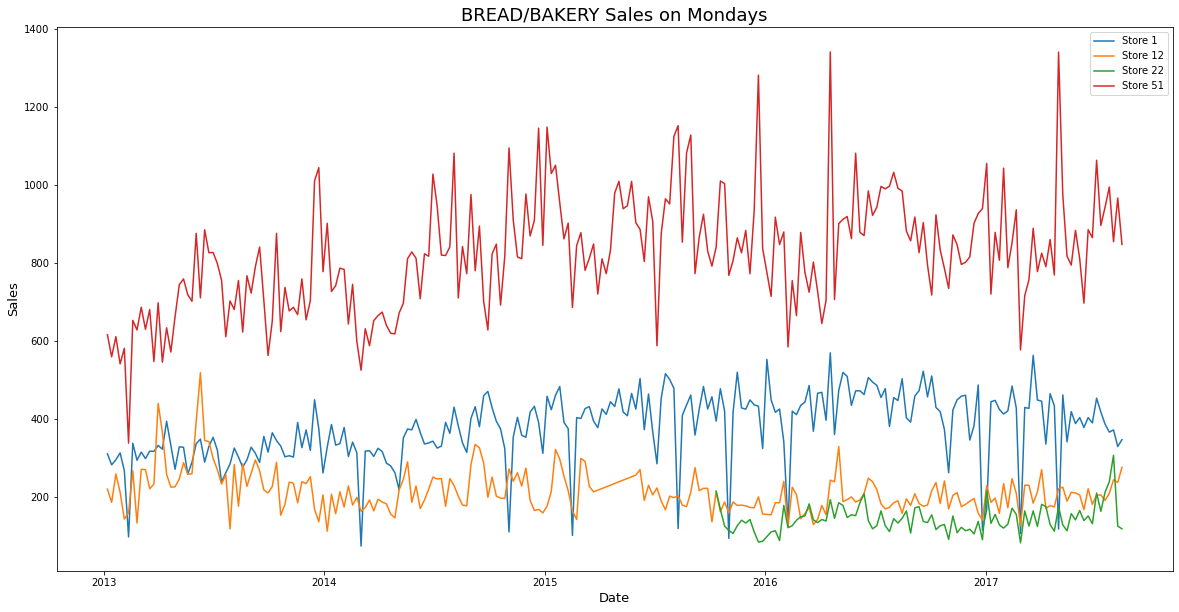

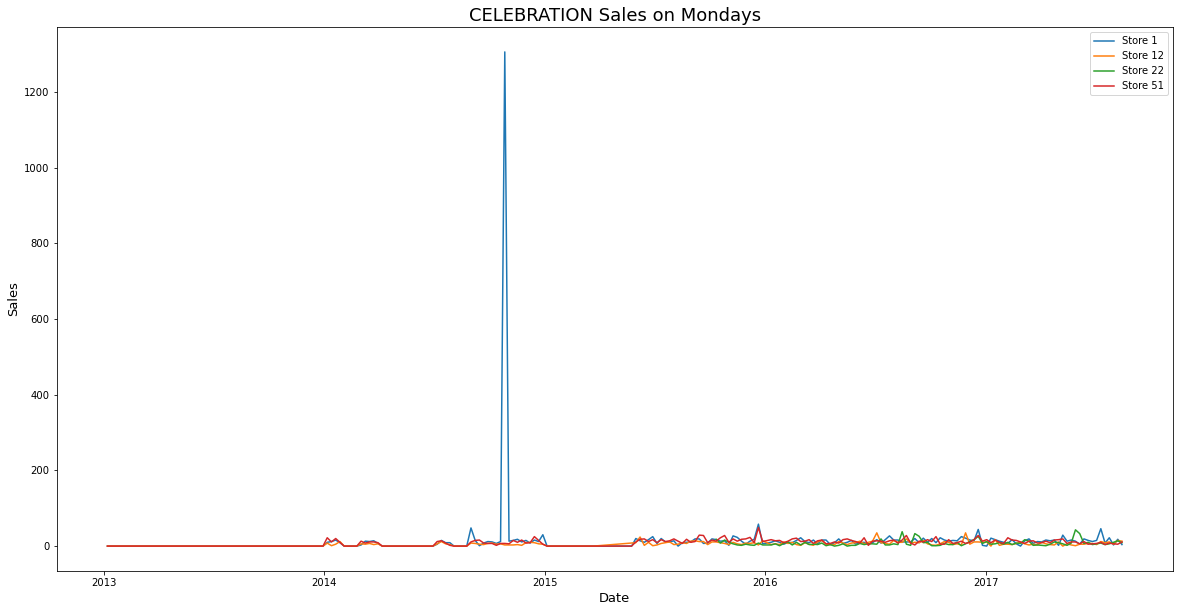

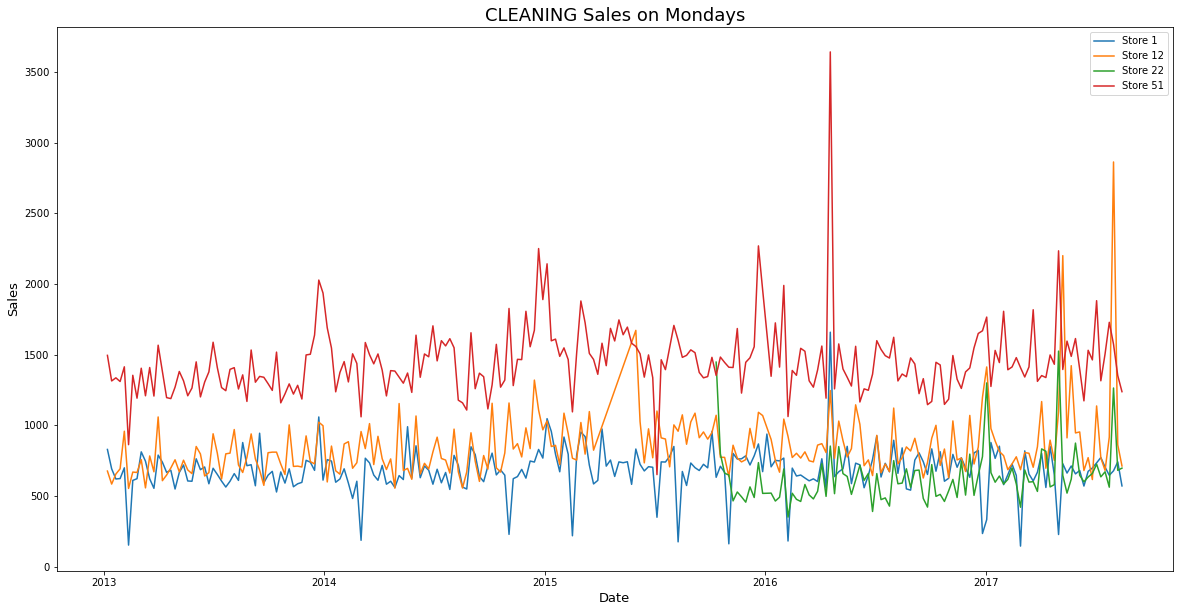

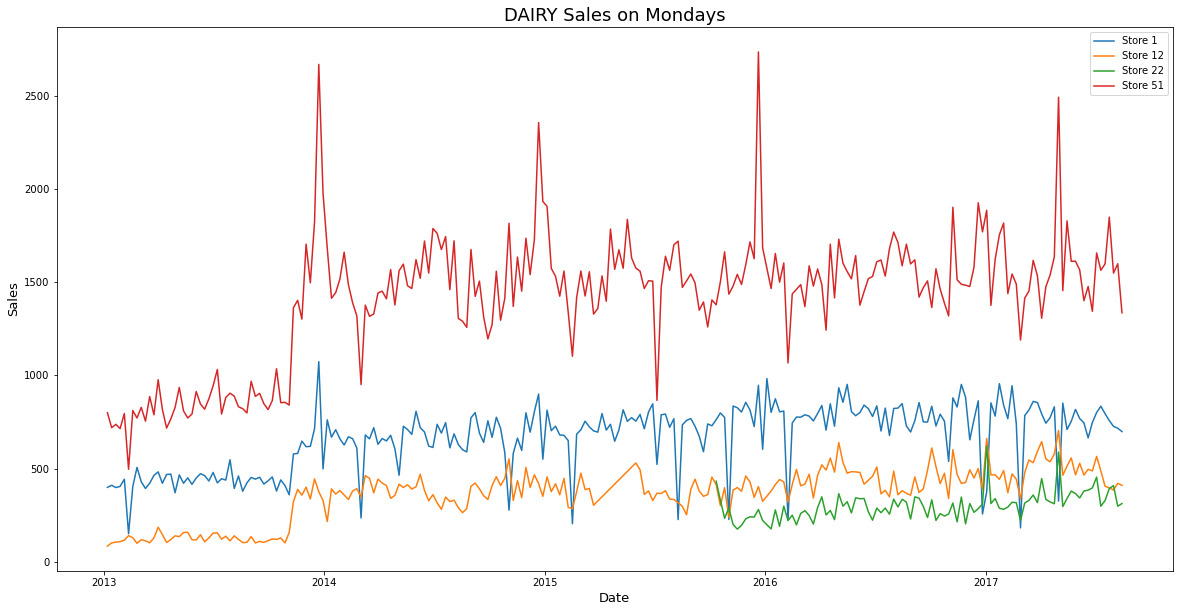

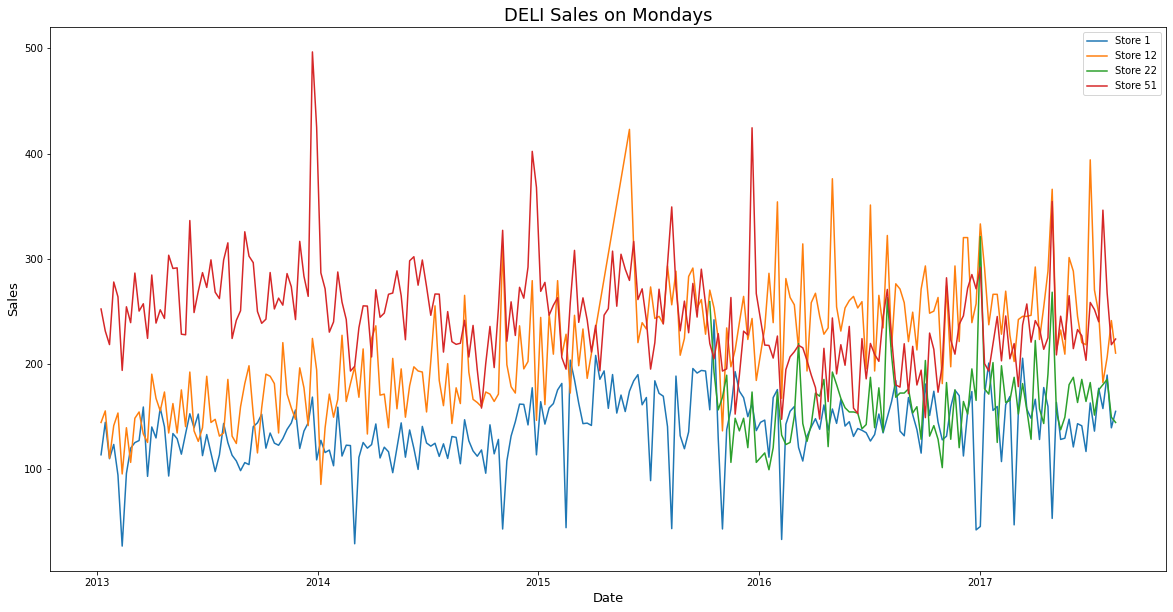

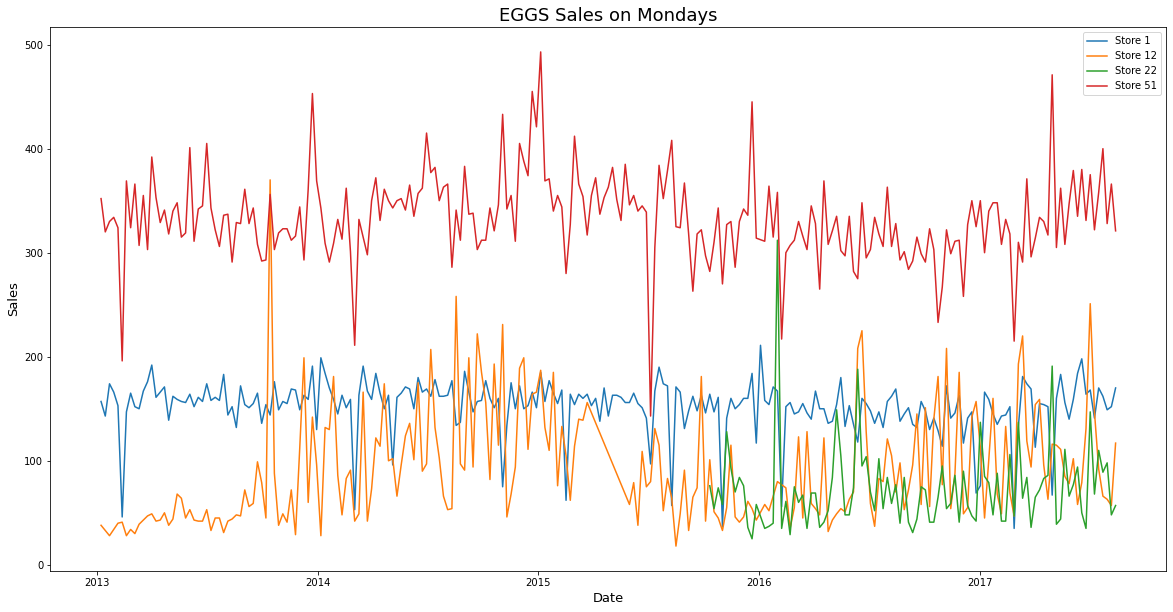

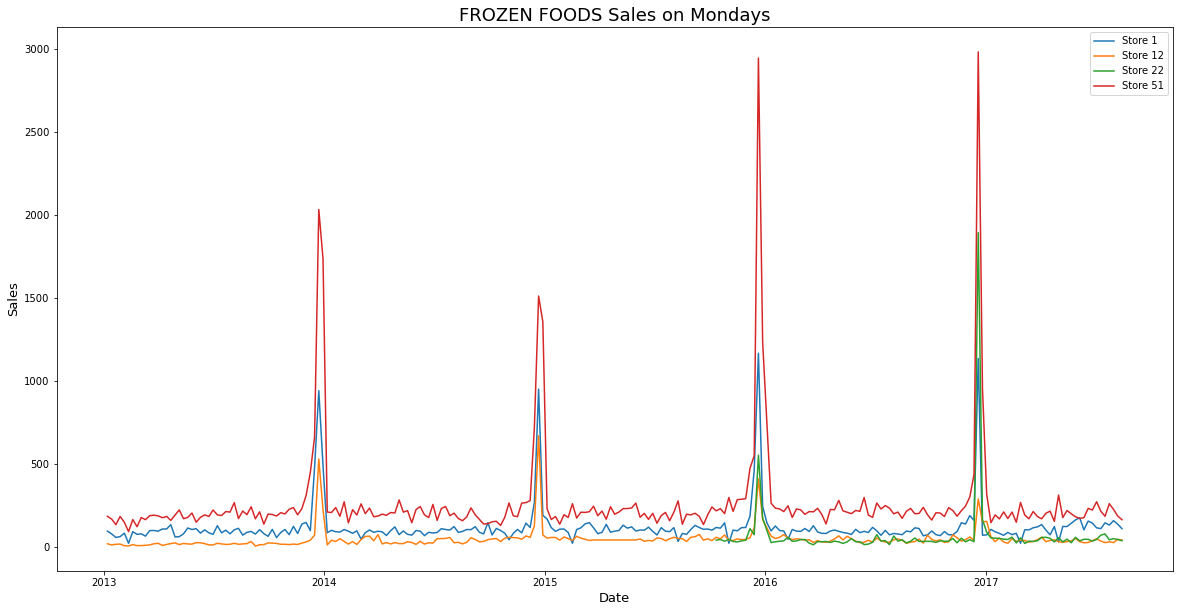

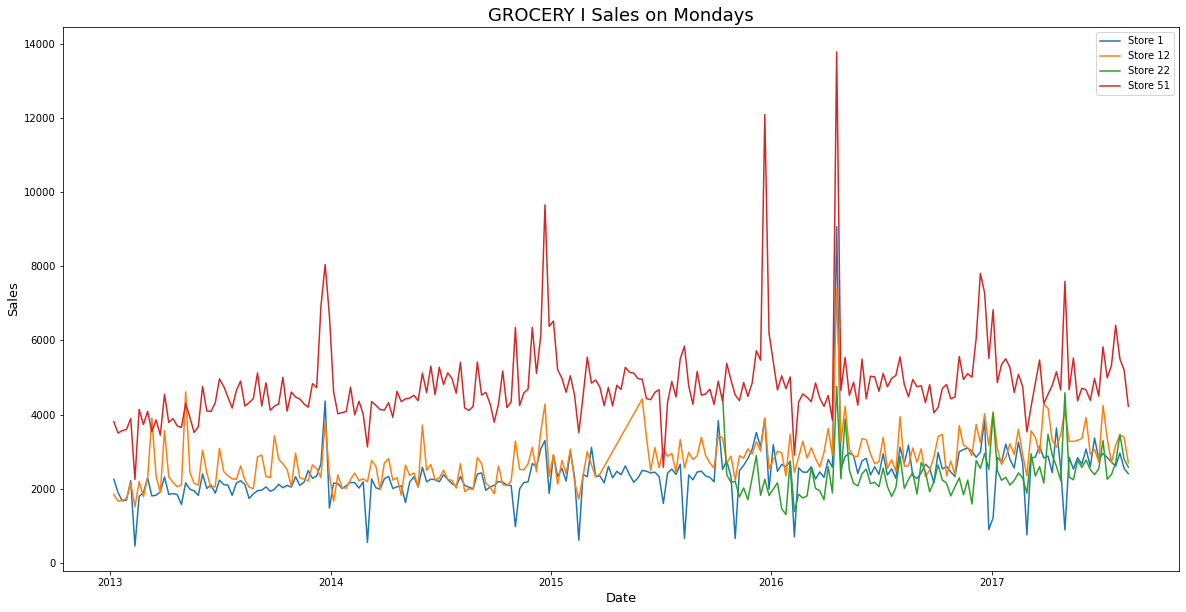

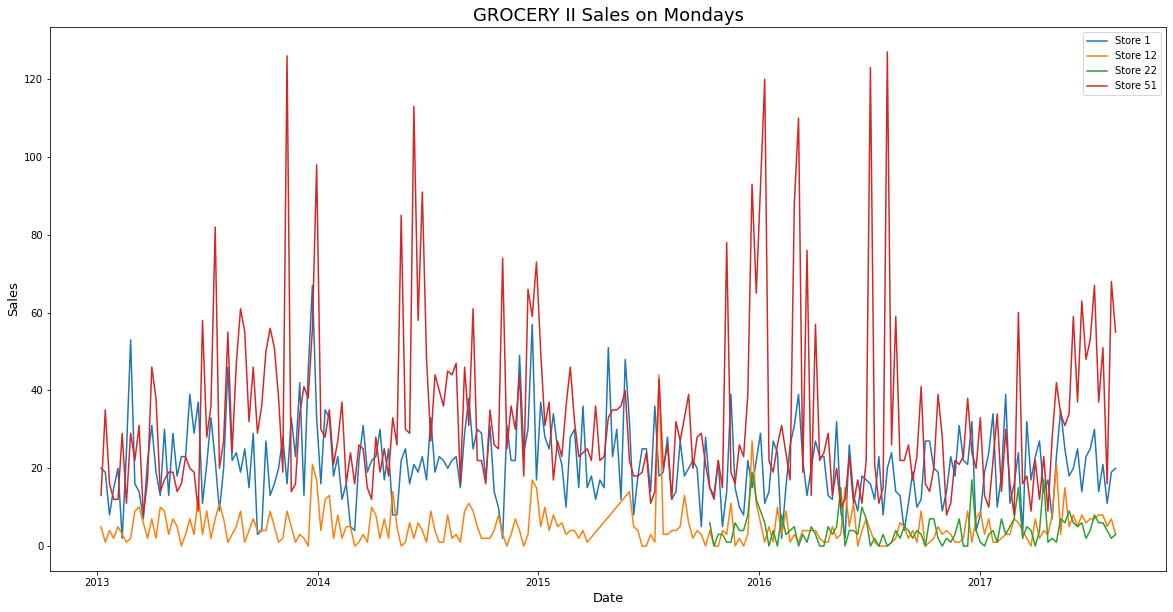

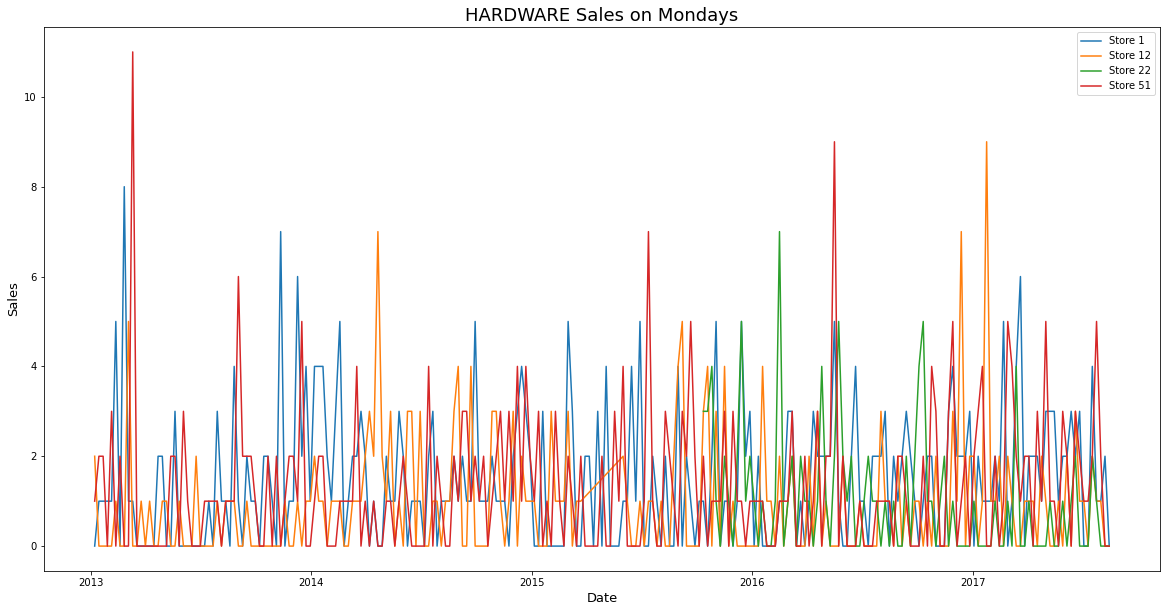

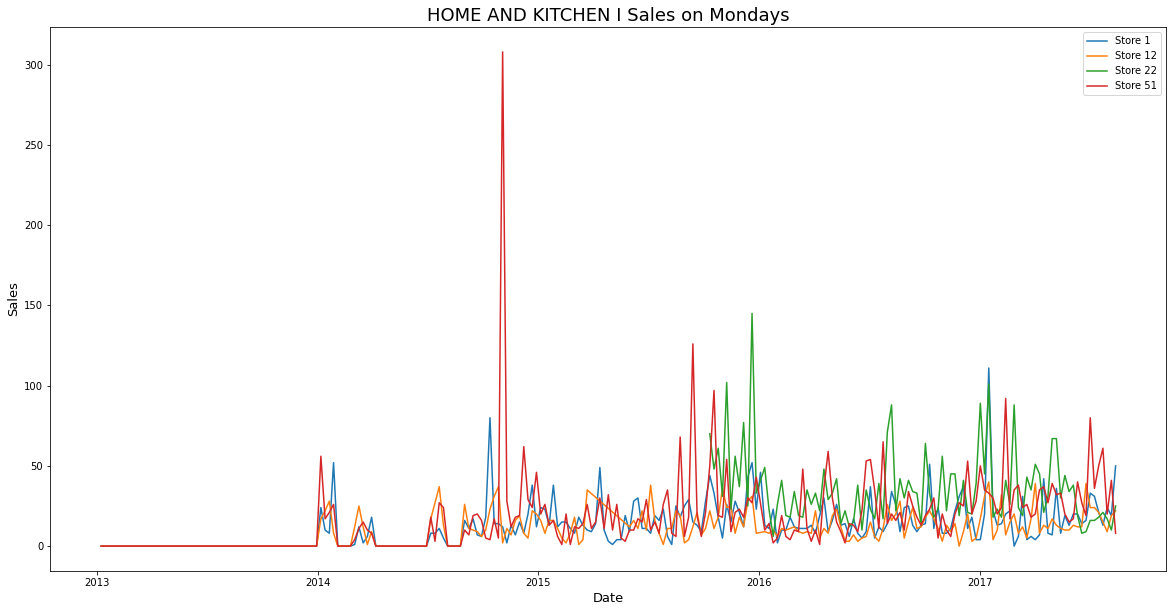

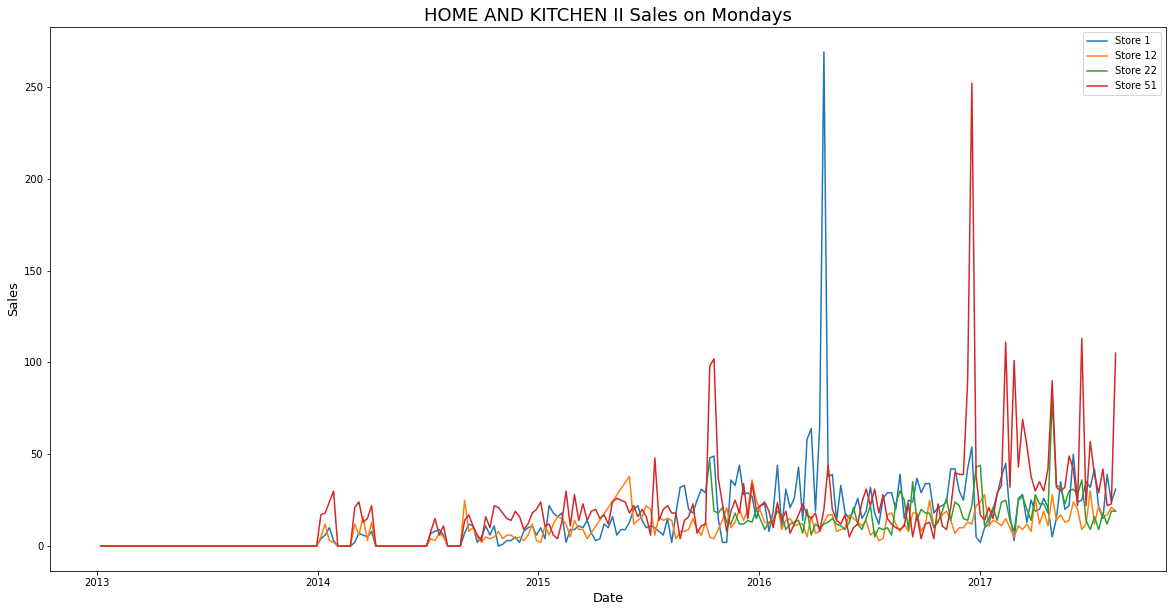

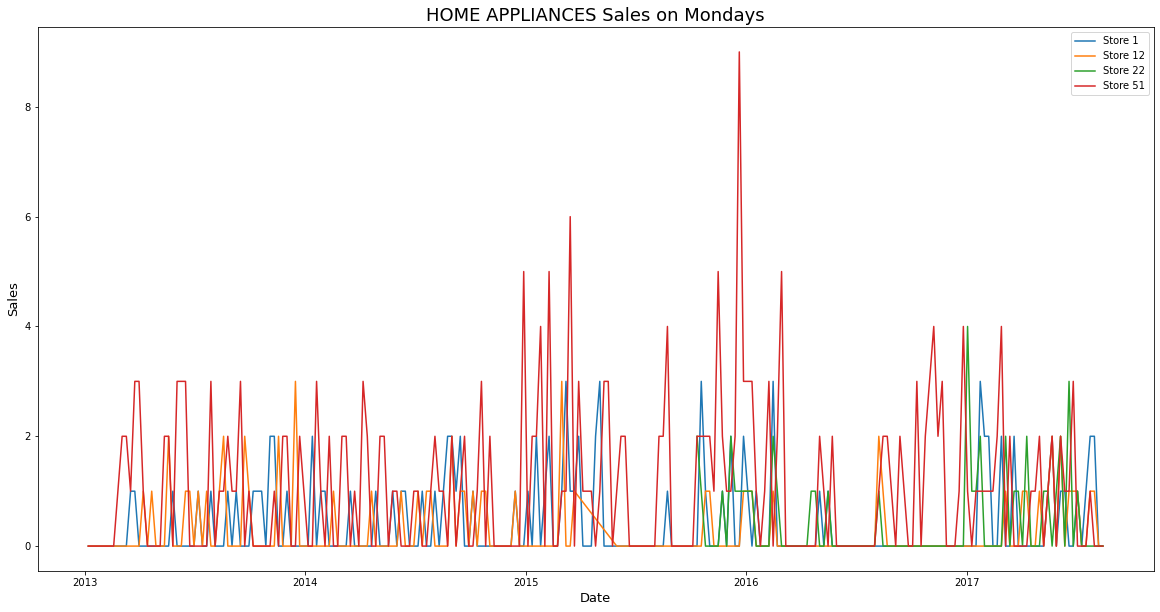

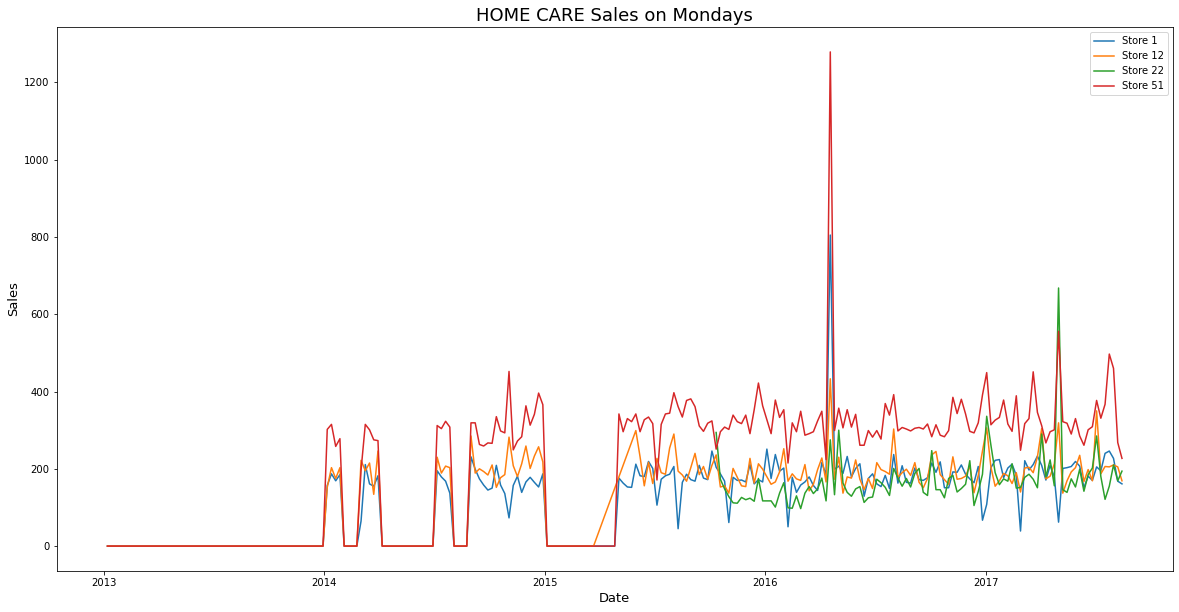

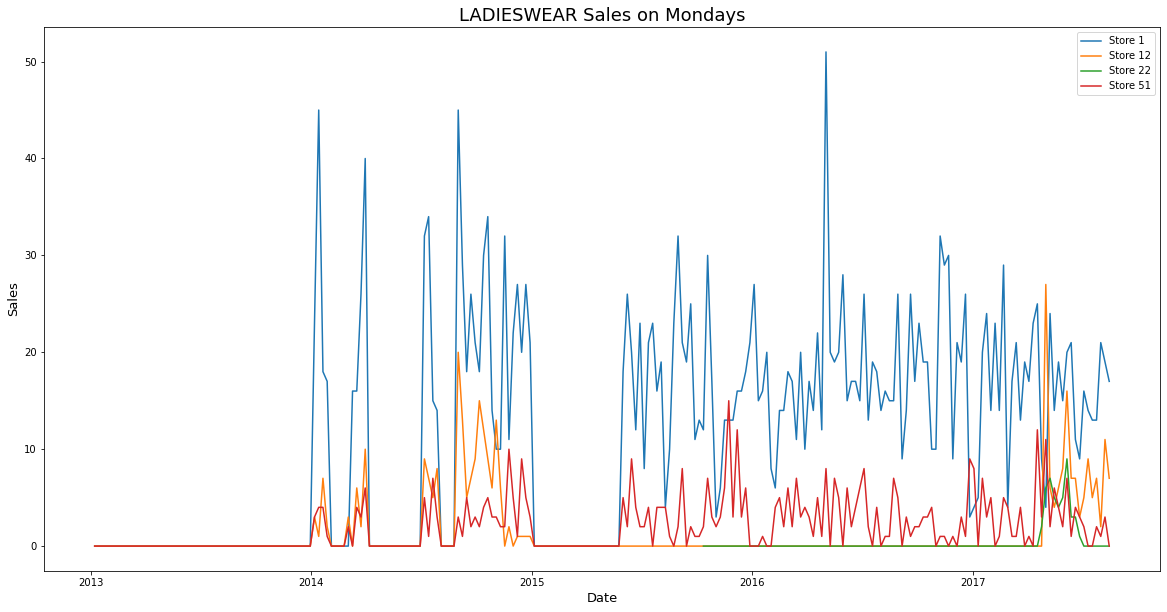

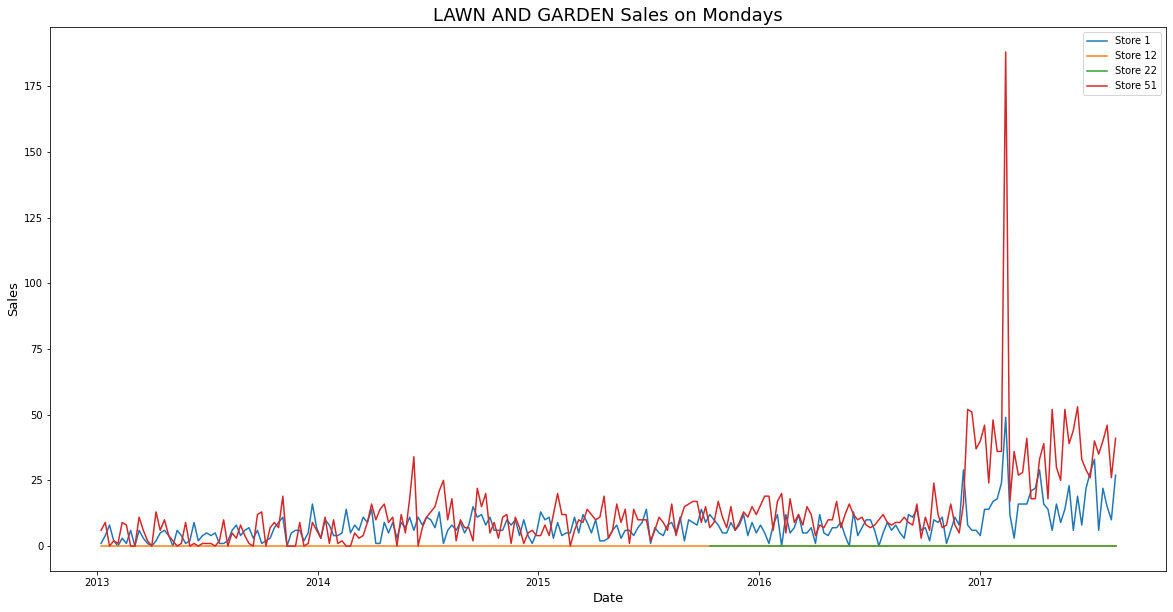

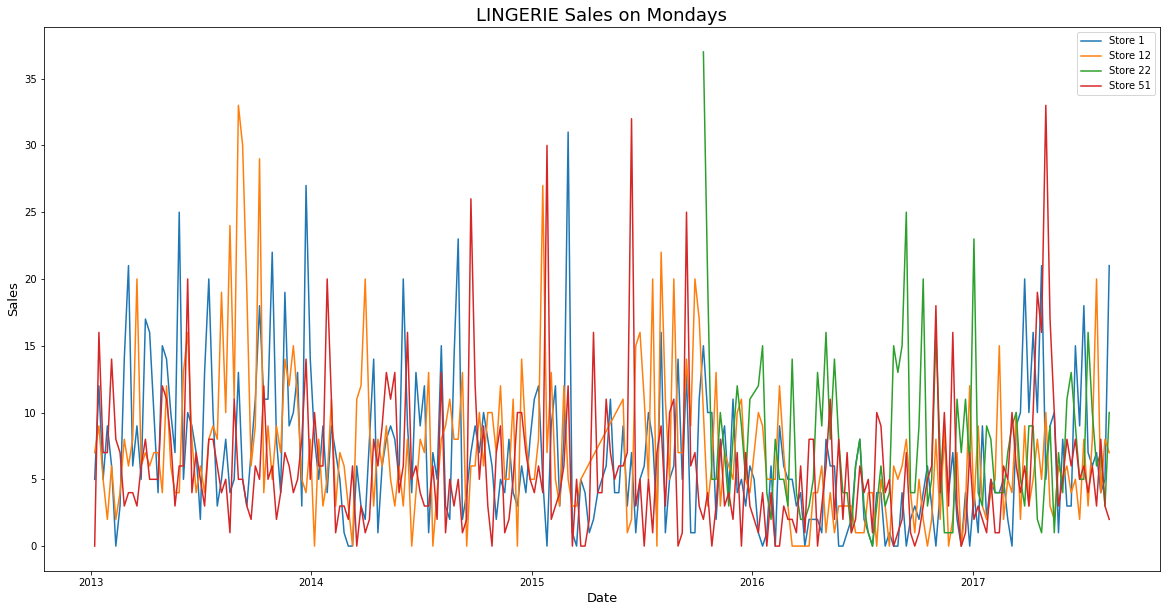

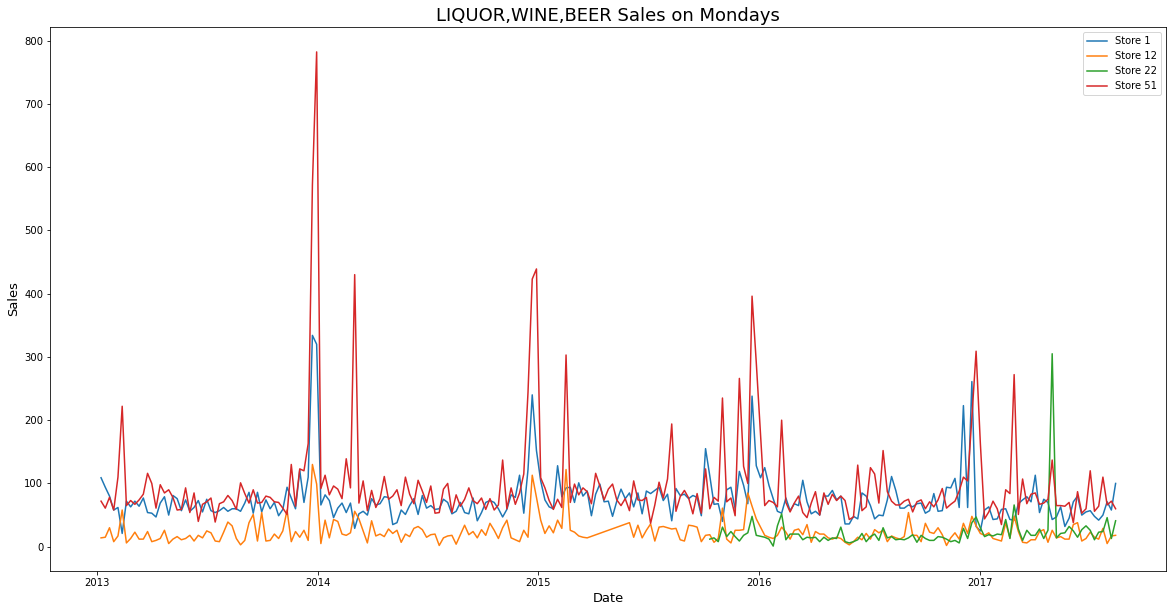

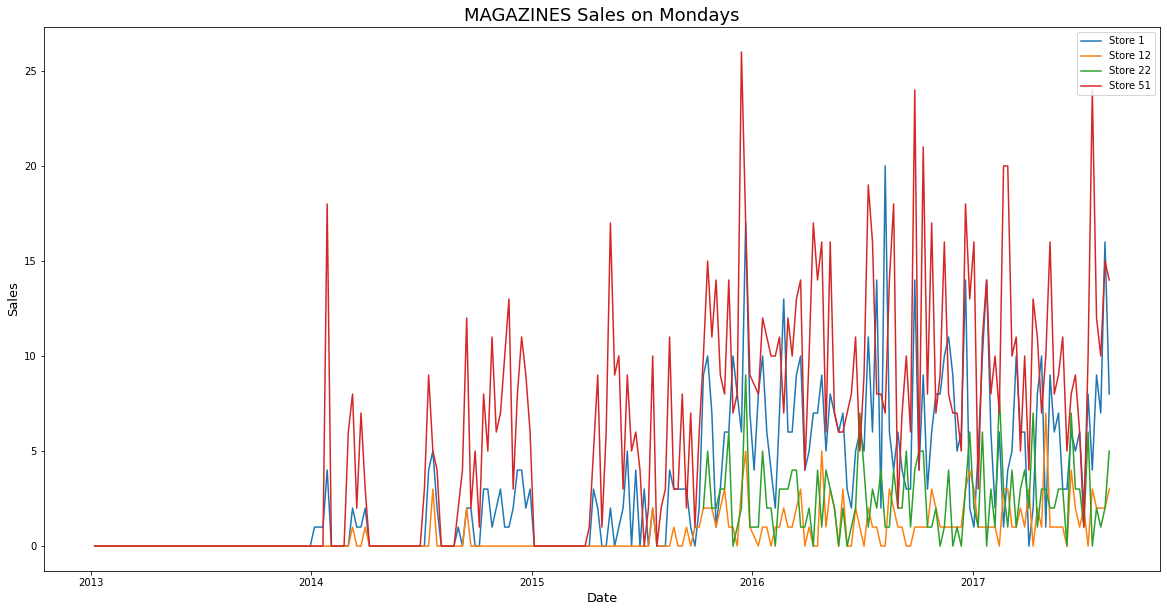

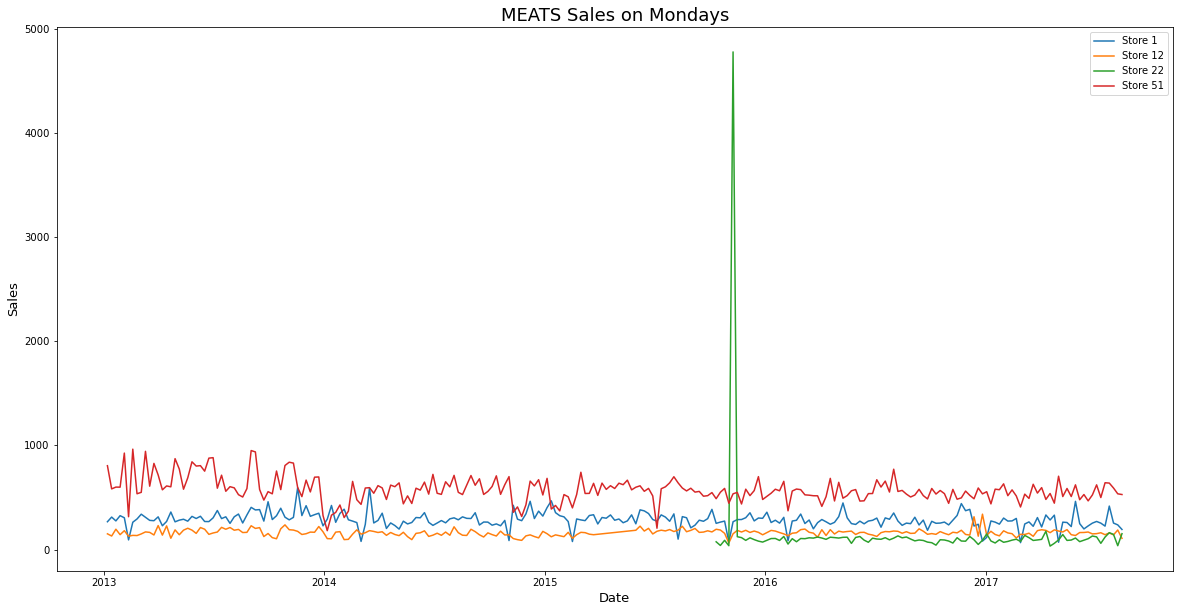

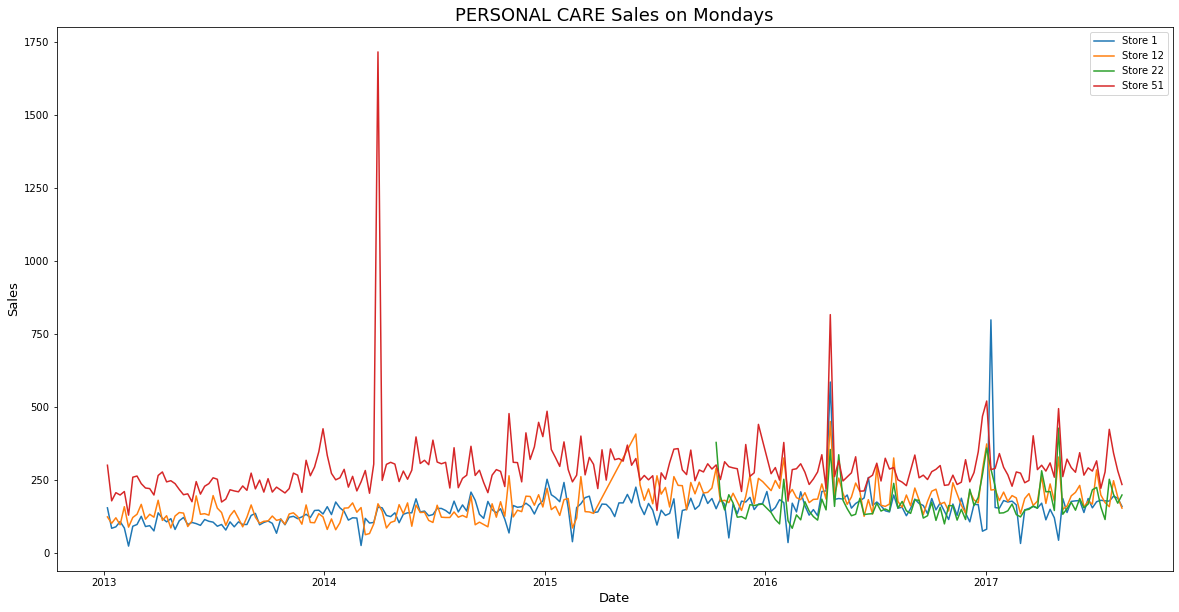

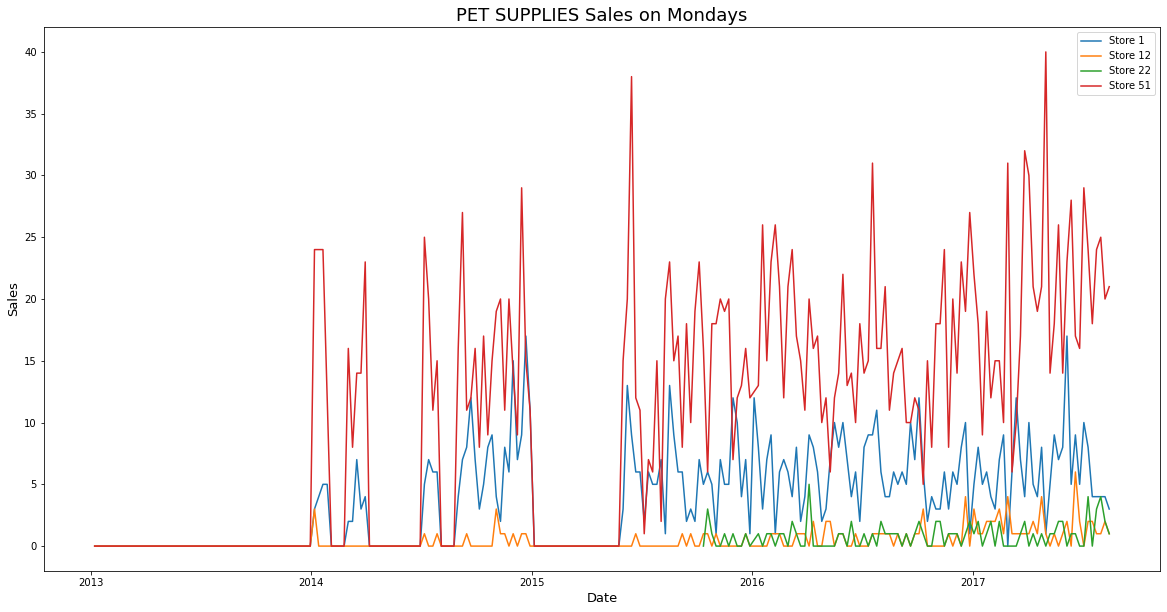

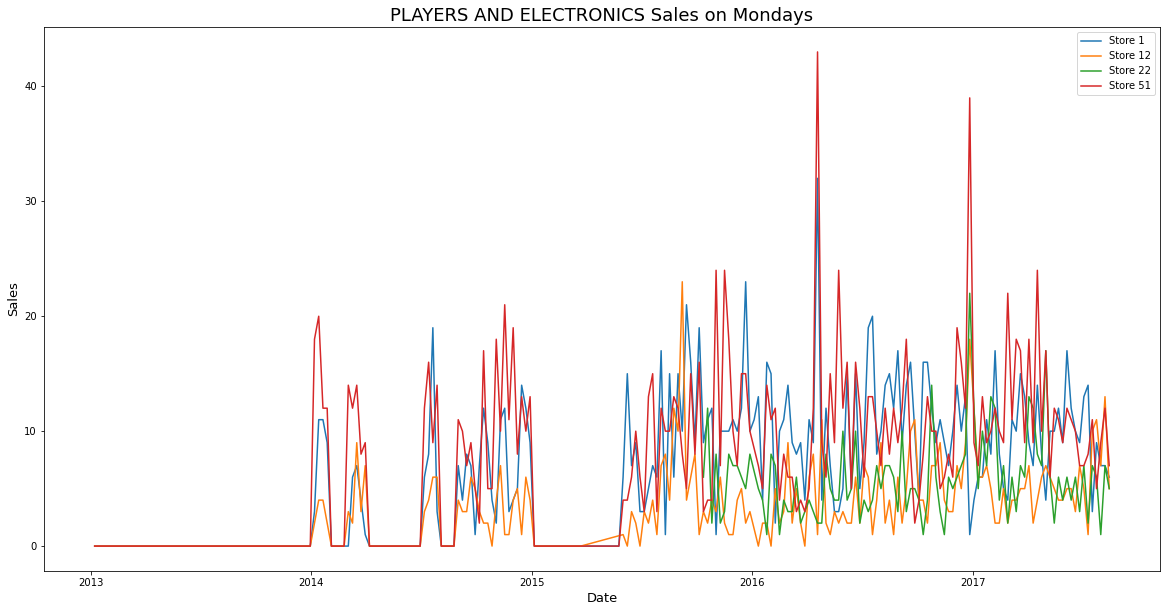

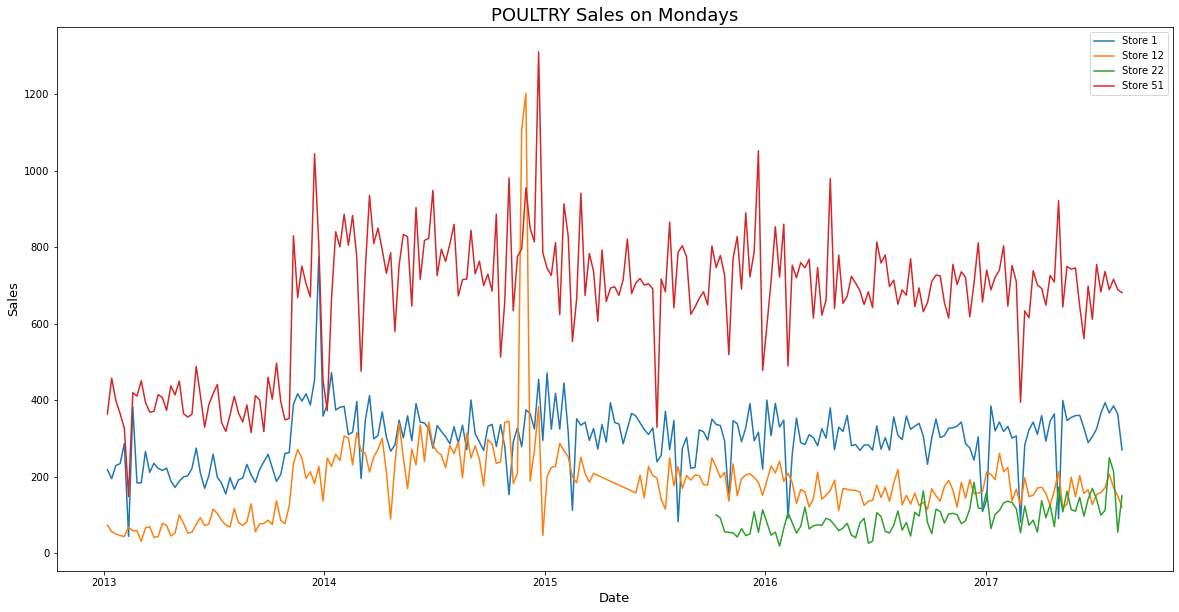

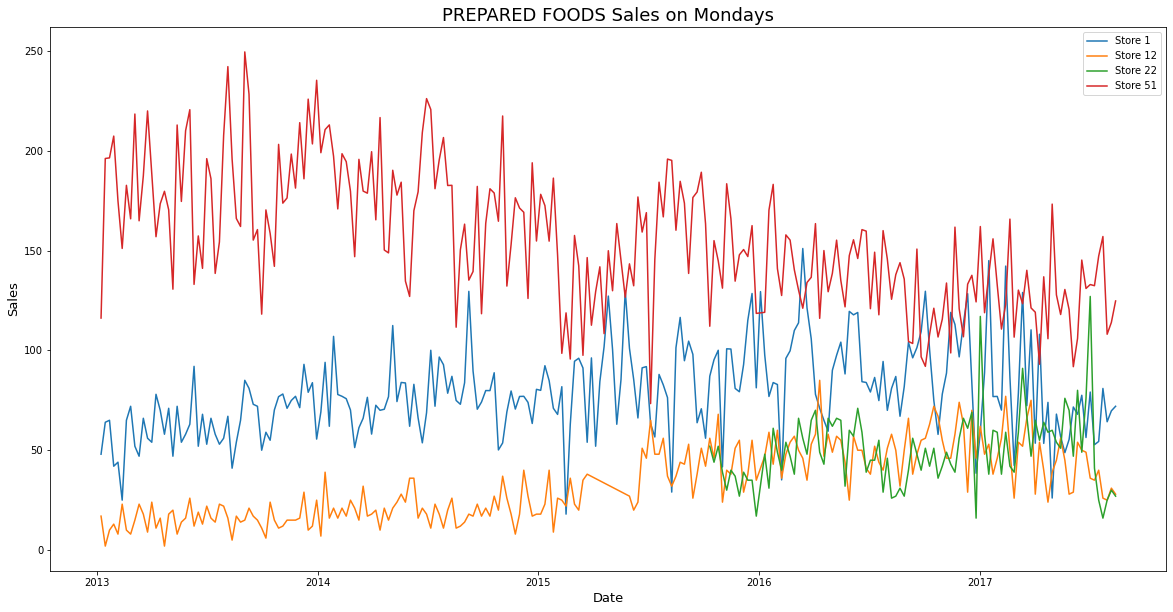

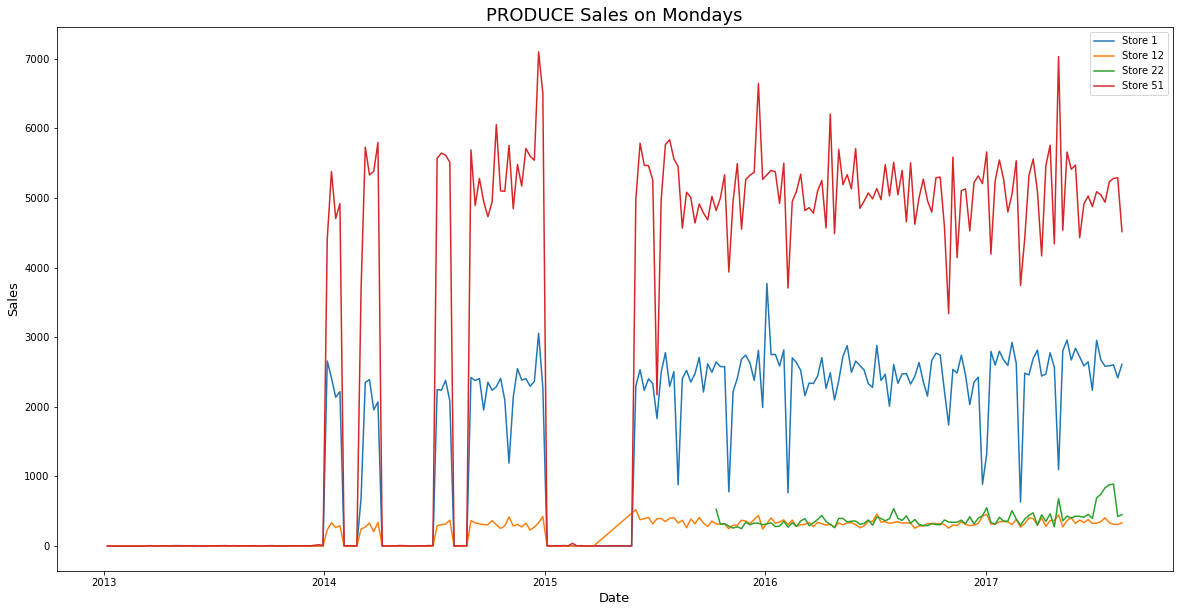

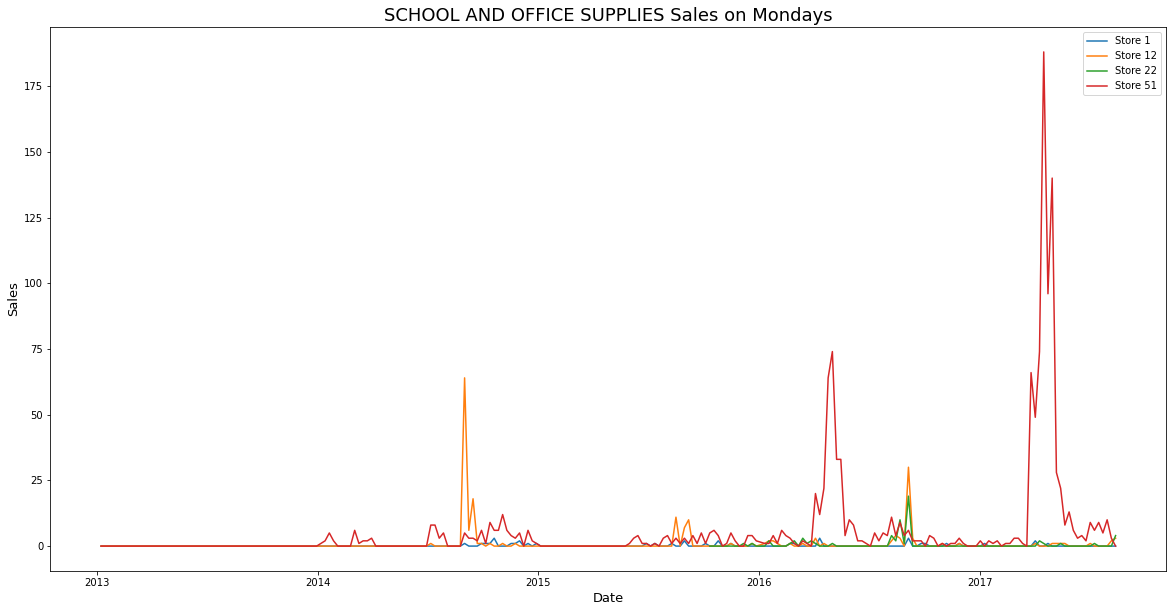

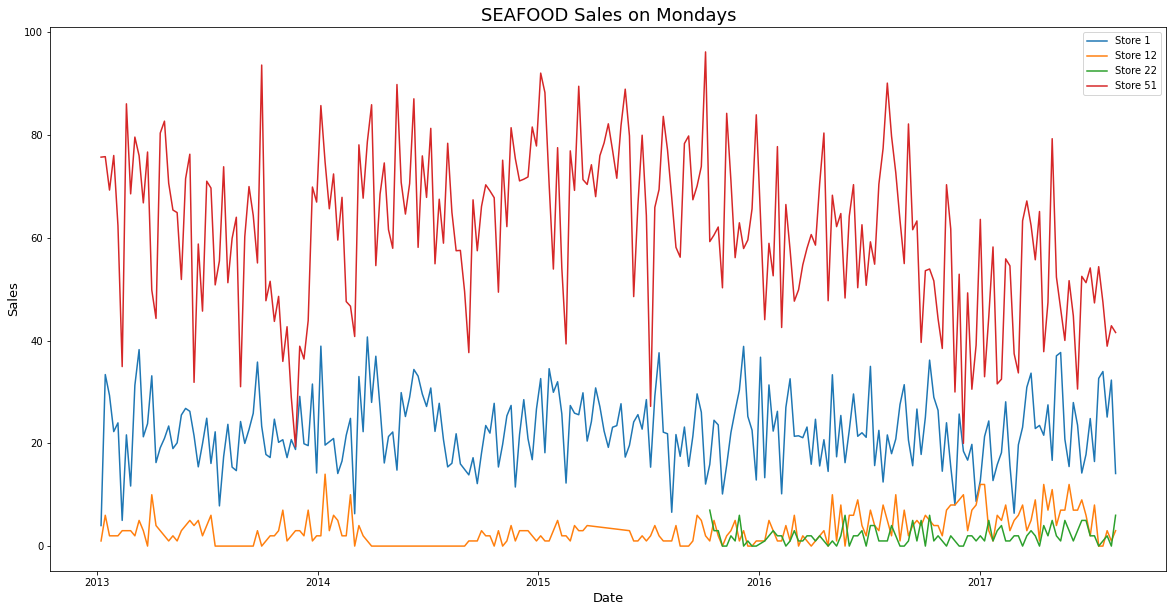

In [271]:
## making a Figure
for product_type in family:
    plt.figure(figsize=(20,10))

    for store_num in [0,11,21,50]:
        temp = data_by_store[store_num][ data_by_store[store_num].day_of_week == 0  ]   # store n monday(0)
        temp = temp[ temp.family == product_type ]                                       # store n monday beverage
        plt.plot(temp.date, temp.sales, label=f"Store {store_num+1}")


    ## Display the Figure
    plt.title(f"{product_type} Sales on Mondays", fontsize=18)
    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Sales", fontsize=13)
    plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
    plt.show()